In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import re

In [2]:
# 验证集和停用词
train = pd.read_csv("../data/train.csv",encoding = 'gb18030')
stopword_list = [k.strip() for k in open('../data/stopword.txt', encoding='utf8').readlines() if k.strip() != '']

In [3]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
#y = train['class']
y = labelEncoder.fit_transform(train['class'])

In [4]:
train['class'].value_counts()

运营者要求    90
法规部署     52
惩罚       37
法规倡议     13
法规定义      7
使用者要求     7
法规目的      6
法规倡导      2
Name: class, dtype: int64

In [5]:
pd.Series(y).value_counts()

7    90
6    52
1    37
3    13
4     7
0     7
5     6
2     2
dtype: int64

In [6]:
def get_cutword(string):
    '''
    jieba分词,正则替换数字
    '''
    string = re.sub("[0-9]"," ",string) # 正则替换数字
    cutWords = [k for k in jieba.cut(string) if k not in stopword_list]
    return cutWords

cutWords_series = train['content'].apply(lambda x: get_cutword(x)) # 得到的是pandas series
cutWords_series.head(10)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\xsong\AppData\Local\Temp\jieba.cache
Loading model cost 0.742 seconds.
Prefix dict has been built succesfully.


0    [保障, 网络安全, 维护, 网络, 空间主权, 国家, 安全, 社会, 公共利益, 保护,...
1    [中华人民共和国, 境内, 建设, 运营, 维护, 使用, 网络, 网络安全, 监督管理, ...
2    [国家, 坚持, 网络安全, 信息化, 发展, 并重, 遵循, 积极, 利用, 科学, 发展...
3    [国家, 制定, 不断完善, 网络安全, 战略, 明确, 保障, 网络安全, 基本, 要求,...
4    [国家, 采取措施, 监测, 防御, 处置, 来源于, 中华人民共和国, 境内外, 网络安全...
5    [国家, 倡导, 诚实, 守信, 健康, 文明, 网络, 行为, 推动, 传播, 社会主义,...
6    [国家, 积极开展, 网络空间, 治理, 网络, 技术, 研发, 标准, 制定, 打击, 网...
7    [国家, 网信, 部门, 负责, 统筹, 协调, 网络安全, 工作, 相关, 监督管理, 工...
8    [网络, 运营者, 开展, 经营, 服务, 活动, 必须, 遵守, 法律, 行政, 法规, ...
9    [建设, 运营, 网络, 网络, 提供, 服务, 应当, 法律, 行政, 法规, 规定, 国...
Name: content, dtype: object

In [7]:
def combine_text(series):
    '''拼接字符串'''
    combined = ' '.join(series)
    return combined

cutWords_series  = cutWords_series.apply(lambda x : combine_text(x))

In [8]:
from sklearn.feature_extraction.text import CountVectorizer 

cv = CountVectorizer(max_features = 150,token_pattern='[\u4e00-\u9fa5_a-zA-Z0-9]{1,}') #汉字
cv_fit = cv.fit_transform(cutWords_series).toarray()
tokens = cv.get_feature_names()
unigram = pd.DataFrame(cv_fit, columns=tokens)
unigram.head()

,一万元,三,下列,不,不得,业务,个人,个人信息,中,中华人民共和国,...,运行,进行,违反,违法,通信,遵守,部门,采取,非经营性,风险
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
cvscore = cross_val_score(nb, unigram, y, cv=10)
print('10折交叉验证准确率为',round(cvscore.mean(),3))

10折交叉验证准确率为 0.503


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [10]:

from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
cvscore = cross_val_score(mnb, unigram, y, cv=10)
print('10折交叉验证准确率为',round(cvscore.mean(),3))

10折交叉验证准确率为 0.542


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [11]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
cvscore = cross_val_score(mnb, unigram, y, cv=10)
print('10折交叉验证准确率为',round(cvscore.mean(),3))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


10折交叉验证准确率为 0.542


In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
reg = AdaBoostClassifier(DecisionTreeClassifier())
cvscore = cross_val_score(reg, unigram, y, cv=10)
print('10折交叉验证准确率为',round(cvscore.mean(),3))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


10折交叉验证准确率为 0.576


In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
cvscore = cross_val_score(rf, unigram, y, cv=10)
print('10折交叉验证准确率为',round(cvscore.mean(),3))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


10折交叉验证准确率为 0.732


In [14]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators=100)
#best = gridcv.best_estimator_
cvscore = cross_val_score(model,unigram, y, cv=10)
print('10折交叉验证准确率为',round(cvscore.mean(),3))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


10折交叉验证准确率为 0.719


In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
clf = model.fit(unigram, y)
y_predict = clf.predict(unigram)

print('Accuracy Score is',accuracy_score(y, y_predict))

Accuracy Score is 0.9953271028037384


In [16]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set_style('white')

In [18]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

   0   1  2   3  4  5   6   7
0  7   0  0   0  0  0   0   0
1  0  37  0   0  0  0   0   0
2  0   0  2   0  0  0   0   0
3  0   0  0  13  0  0   0   0
4  0   0  0   0  7  0   0   0
5  0   0  0   0  0  6   0   0
6  0   0  0   0  0  0  51   1
7  0   0  0   0  0  0   0  90
Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.98076923 0.01923077]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]]


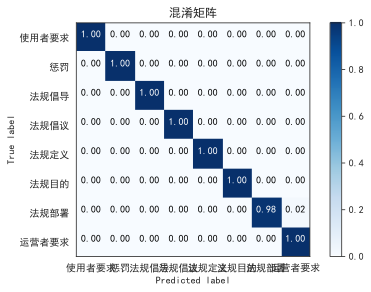

In [19]:
print(pd.DataFrame(confusion_matrix(y, y_predict)))

class_names = [str(x) for x in range(0,8)]
clname = ['使用者要求','惩罚','法规倡导','法规倡议','法规定义','法规目的','法规部署','运营者要求']
plot_confusion_matrix(confusion_matrix(y, y_predict),
                      classes=clname, normalize = True, 
                      title='混淆矩阵')